# <font color=red>미니 프로젝트 : 가위바위보 분류기</font>

세상에서 가장 완벽한 게임! __가위바위보__

누구나 한번쯤은 가위바위보를 해본 경험이 있을 것이다. 누구나 상대방의 손 모양을 보고 가위인지, 바위인지, 보인지 판단 할 수 있다.  
그렇다면 컴퓨터도 과연 손 모양을 보고 가위, 바위, 보를 분류할 수 있을까?    

__가위바위보 분류기를 만들어보자!__

# Attempt - 1
## 1. 데이터 준비
### 데이터 만들기
가위, 바위, 보 손모양이 담긴 이미지를 각각 100장씩 만들어 모델을 학습시키려고한다.  
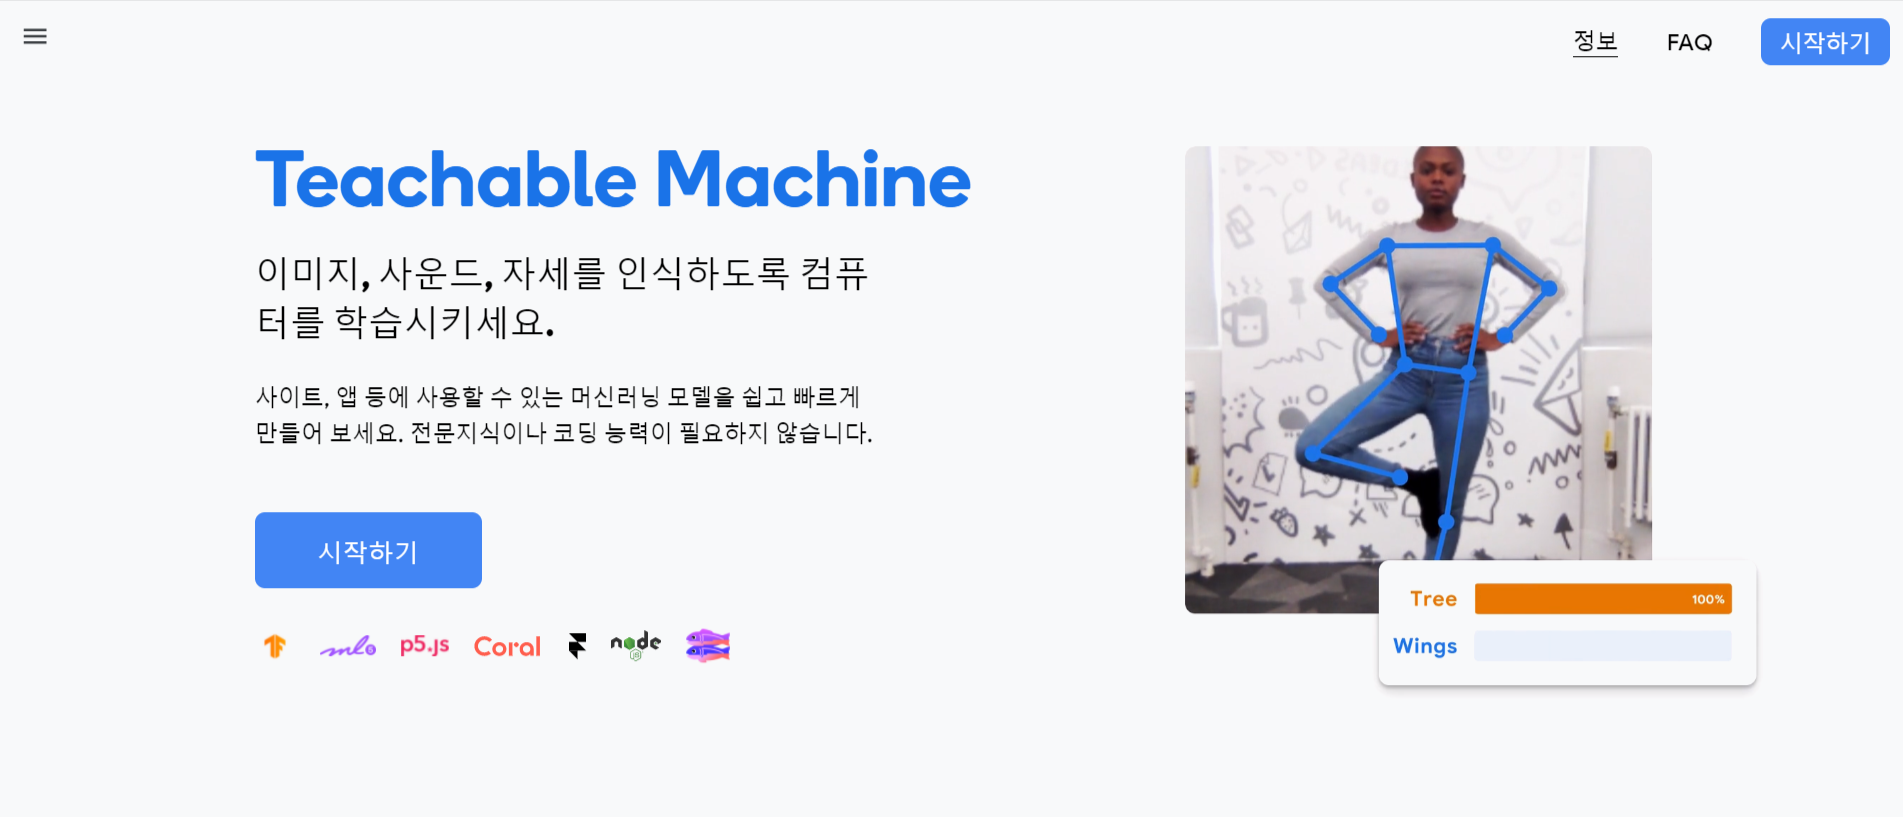

구글의 [teachable machine](https://teachablemachine.withgoogle.com/) 사이트를 통해 300장의 이미지를 쉽게 만들수 있다. 

사이트를 통해 만든 이미지는 224x224 의 크기를 갖는다. 이 이미지들을 MNIST와 동일한 28x28 사이즈로 변경하여 사용할 것이다.

### 이미지 사이즈 변경

이미지 사이즈 변경을 위해 PIL 라이브러리를 사용한다. 만약 PIL 라이브러리가 설치되지 않은 경우 `pip install pillow` 를 통해 설치할 수 있다.

In [1]:
from PIL import Image
import os, glob

먼저 가위 이미지부터 28x28 의 이미지로 resize 한다.

In [2]:
def resize_images(img_path):
    
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
scissor_image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data/scissor"
resize_images(scissor_image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


계속해서 바위, 보 이미지도 resize 를 진행한다.

In [3]:
rock_image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data/rock"
paper_image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data/paper"

resize_images(rock_image_dir_path)    # 바위 이미지 resize
print("바위 이미지 resize 완료!")
resize_images(paper_image_dir_path)   # 보 이미지 resize
print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


숫자 손글씨 이미지 분류기는 mnist.load_data() 라는 함수로 데이터를 불러왔다.  
이와 같이, 가위 바위 보 데이터를 불러오는 load_data() 함수를 만들자.  
  
  
  라벨링시 __가위:0, 바위:1, 보:2__ 로 라벨링하겠다.

In [4]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

`load_data()` 함수를 통해 가위 바위 보 데이터를 불러오자.

In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


다음과 같이 입력값인 x_train 데이터는 `(데이터개수, 이미지 크기 x, 이미지 크기 y, 채널수)` 형태로 생성된다.  
  
  
_컬러 이미지이기 때문에 R,G,B 값으로 표현되어 3개의 채널수를 가진다_

라벨:  0


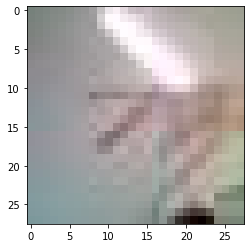

In [6]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

## 2. 딥러닝 네트워크 설계

tf.keras 의 Sequential API 를 이용하여 LeNet 이라는 딥러닝 네트워크를 설계했다.

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

## 3. 모델 학습시키기

`epochs` 값은 10 으로 지정하여 모델을 학습시킨다.

In [9]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 5s 185ms/step - loss: 1.0932 - accuracy: 0.3700
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0537 - accuracy: 0.5923
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0180 - accuracy: 0.4206
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9180 - accuracy: 0.5787
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9025 - accuracy: 0.5798
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7955 - accuracy: 0.7029
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7199 - accuracy: 0.7261
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.7541
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5950 - accuracy: 0.7495
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5223 - accuracy: 0.7720


## 4. 모델 성능 평가

다른 사람의 가위바위보 이미지 300장을 이용하여 내 모델이 얼마나 잘 맞는지 성능평가를 해보자.

먼저 test set 을 28x28 의 이미지로 resize 해야한다.

In [10]:
test_scissor_image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data/test/scissor"
resize_images(test_scissor_image_dir_path)   # 테스트 가위 이미지 resize

test_rock_image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data/test/rock"
resize_images(test_rock_image_dir_path)   # 테스트 바위 이미지 resize

test_paper_image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data/test/paper"
resize_images(test_paper_image_dir_path)   # 테스트 보 이미지 resize

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


위에서 정의한 `load_data()` 함수를 통해 test 폴더 안에 있는 가위바위보 테스트 이미지를 불러오자.

In [11]:
image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data/test"
(x_test, y_test)=load_data(image_dir_path)

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose = 2)

print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

10/10 - 0s - loss: 147.5321 - accuracy: 0.3333
test_loss : 147.53211975097656
test_accuracy : 0.3333333432674408


test set 으로 성능 평가를 한 결과 __약 33% 의 정확도__ 가 나온다.  
가위, 바위, 보 셋 중에 아무거나 골라도 약 33.3% 의 확률로 정답을 고르니..  

거의 갓 태어난 아기가 찍는 듯한 모델의 성능이 나왔다.

그럼 잘못 예측된 데이터들을 한번 자세히 살펴보자

In [13]:
predicted_result = model.predict(x_test)  
predicted_labels = np.argmax(predicted_result, axis=1)

예측확률분포: [0. 1. 0.]
라벨: 2, 예측결과: 1


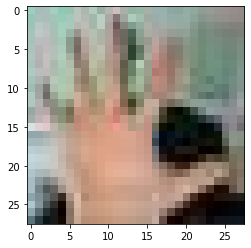

예측확률분포: [0.000000e+00 2.062881e-27 1.000000e+00]
라벨: 0, 예측결과: 2


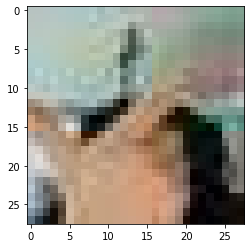

예측확률분포: [0. 1. 0.]
라벨: 2, 예측결과: 1


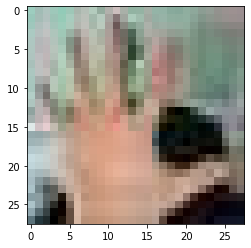

예측확률분포: [0. 1. 0.]
라벨: 2, 예측결과: 1


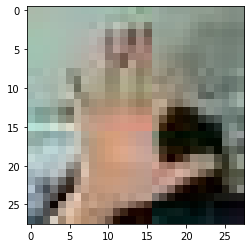

예측확률분포: [0. 0. 1.]
라벨: 1, 예측결과: 2


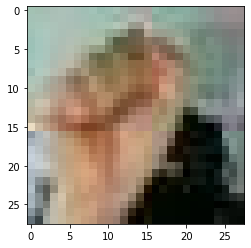

In [14]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모음
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑기
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

예측 결과가 터무니 없이 틀린것을 확인 할 수 있다.  
그 이유를 예상해보면
- training set 개수의 부족
- training set 과 test set 은 서로 다른 사람이 다른 공간에서 찍은 이미지이므로 배경, 밝기, 자세 등이 매우 다름
- 이미지 데이터의 크기를 224x224 -> 28x28 로 변경하면서 생긴 해상도 저하
- 최적의 하이퍼파라미터 값을 못찾음

등이 있다.

----

# Attempt - 2

너무 터무니 없는 성능의 모델을 만들었기에 실패했던 경험을 토대로 다시 가위 바위 보 분류기를 만들어보겠다.

##  1. 데이터 준비

이전 모델에서 보완해야할 점은
- 이미지 데이터 resize 를 (224x224 -> 28x28) 에서 (224x224 -> 112x112) 로 변경
- 더 많은 데이터 셋 확보 (여러 사람의 데이터를 가져옴)
- 가져온 데이터 셋을 training set, validation set, test set 을 무작위로 섞어 training set, validation set 으로 모델을 학습 시킨 후 test set으로 최종 모델 성능 평가

이전 모델 데이터 부족으로 인한 성능 저하를 개선 할 필요성을 느꼈다.



따라서 원래의 데이터와 많은 사람들의 데이터들을 가위, 바위, 보 각각 1527개 씩 모아 총 4581 개의 이미지 데이터를 준비하였다.

### 이미지 사이즈 변경
224x224 크기의 이미지 데이터를 112x112 크기로 resize 한다. 앞에서 사용한 PIL 라이브 러리와 `resize_images` 함수를 활용하여 `target_size` 를 (112,112) 로 바꾼 새로운 함수를 정의하자.

In [15]:
def resize_images_new(img_path):
    
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 112x112 사이즈로 바꾸어 저장
    target_size=(112,112)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

`resize_images_new` 함수를 통해 가위 바위 보 이미지의 사이즈를 변경한다.

In [16]:
scissor_new_image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data_new/scissor"
resize_images_new(scissor_new_image_dir_path)

print("가위 이미지 resize 완료!")

rock_new_image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data_new/rock"
resize_images_new(rock_new_image_dir_path)

print("바위 이미지 resize 완료!")

paper_new_image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data_new/paper"
resize_images_new(paper_new_image_dir_path)

print("보 이미지 resize 완료!")

1527  images to be resized.
1527  images resized.
가위 이미지 resize 완료!
1527  images to be resized.
1527  images resized.
바위 이미지 resize 완료!
1527  images to be resized.
1527  images resized.
보 이미지 resize 완료!


이전 시도에서 사용한 방식과 똑같이 가위 바위 보 데이터를 불러오는 `load_data_new()` 함수를 만들자.

이전 시도와 동일하게 라벨링시 가위:0, 바위:1, 보:2 로 라벨링하겠다.

In [17]:
def load_data_new(img_path, number_of_data=4581):  # 가위바위보 이미지 개수 총합에 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=112
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("전체데이터(x_dataset)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

`load_data_new()` 함수를 통해 가위 바위 보 데이터를 불러오자.

In [18]:
image_dir_path = os.getenv("HOME") + "/aiffel/ep01_data_new"
(x_dataset, y_dataset)=load_data_new(image_dir_path)

print(f"x_dataset shape: {x_dataset.shape}")
print(f"y_dataset shape: {y_dataset.shape}")

전체데이터(x_dataset)의 이미지 개수는 4581 입니다.
x_dataset shape: (4581, 112, 112, 3)
y_dataset shape: (4581,)


이제 불러온 전체 데이터를 training set& validation set, test set 으로 나누어야한다.   
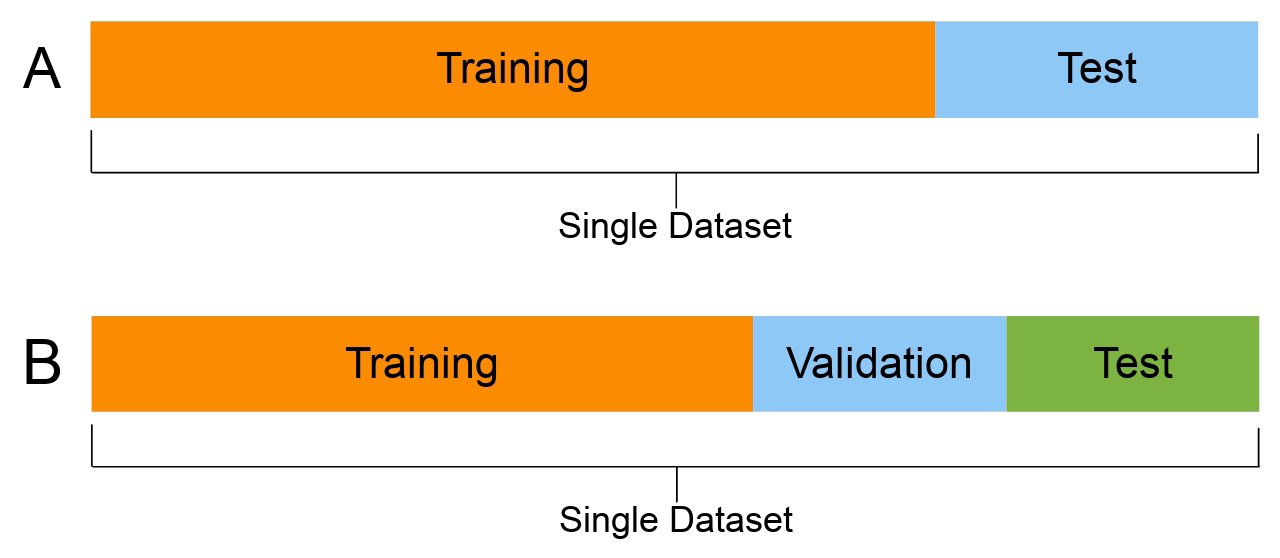
<center>출처 : https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets</center>

training set 과 validation set 을 통해 모델을 학습시키고 최종으로 test set 을 통해 모델의 성능을 평가하기 위해 이런 방식을 사용한다.자세한 내용은 블로그에 정리하겠다.   
-> 링크 추가예정

In [19]:
def train_val_test_split(ds, ds_size, sd,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # trainning set, validation set, test set 을 동일하게 섞기 위해 seed 를 설정
        ds_shuffled = np.random.RandomState(seed=sd).permutation(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds_shuffled[0:train_size]    
    val_ds = ds_shuffled[train_size:train_size+val_size]
    test_ds = ds_shuffled[train_size+val_size:]
    
    return train_ds, val_ds, test_ds

In [20]:
x_train_new, x_val_new, x_test_new = train_val_test_split(x_dataset,4581,42)
y_train_new, y_val_new, y_test_new = train_val_test_split(y_dataset,4581,42)

trainning set, validation set, test set 을 동일하게 섞기 위해 seed 를 설정하였고 임의로 42 라는 값을 넣었다. trainning set, validation set, test set 을 바꿔서 모델을 학습하고자 할때는 세번째 인자인 sd(현재는 42) 값을 바꾸면 된다.

In [21]:
print(x_train_new.shape)
print(x_val_new.shape)
print(x_test_new.shape)

(3664, 112, 112, 3)
(458, 112, 112, 3)
(459, 112, 112, 3)


x_train_new, x_val_new, x_test_new 가 각각 3664개, 458개, 459개씩 나뉘었다.  

In [22]:
print(y_train_new.shape)
print(y_val_new.shape)
print(y_test_new.shape)

(3664,)
(458,)
(459,)


y_train_new, y_val_new, y_test_new 또한 각각 3664개, 458개, 459개씩 나뉘었다.  
이미지 데이터와 라벨이 잘 들어갔는지 확인해보자.

라벨:  2


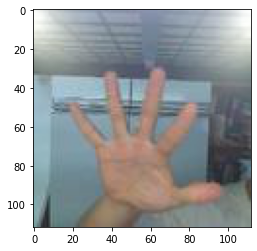

In [23]:
plt.imshow(x_train_new[0])
print('라벨: ', y_train_new[0])

라벨:  0


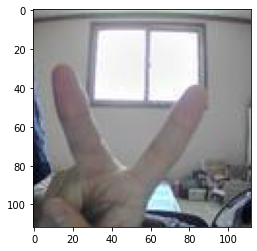

In [24]:
plt.imshow(x_val_new[0])
print('라벨: ', y_val_new[0])

라벨:  2


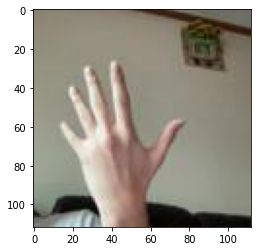

In [25]:
plt.imshow(x_test_new[0])
print('라벨: ', y_test_new[0])

데이터와 라벨이 올바르게 나누어진 것을 볼 수 있다.

## 2. 딥러닝 네트워크 설계

이전 시도와 동일한 방법으로 딥러닝 네트워크를 설계한다.  

tf.keras 의 Sequential API 를 이용하여 LeNet 이라는 딥러닝 네트워크를 설계했다.

In [26]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(112,112,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 110, 110, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                692256    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

## 3. 모델 학습시키기

In [31]:
x_train_new_norm = x_train_new / 255.0

모델을 학습 시키기 전에 x_train_new, x_val_new 데이터를 0~1 사이의 값으로 정규화 시켰다.

In [29]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_new_norm, y_train_new, epochs=10)

Epoch 1/10
115/115 [==============================] - 6s 30ms/step - loss: 1.0158 - accuracy: 0.5085
Epoch 2/10
115/115 [==============================] - 1s 12ms/step - loss: 0.3480 - accuracy: 0.8783
Epoch 3/10
115/115 [==============================] - 1s 12ms/step - loss: 0.1666 - accuracy: 0.9521
Epoch 4/10
115/115 [==============================] - 1s 12ms/step - loss: 0.0625 - accuracy: 0.9883
Epoch 5/10
115/115 [==============================] - 1s 12ms/step - loss: 0.0316 - accuracy: 0.9954
Epoch 6/10
115/115 [==============================] - 1s 12ms/step - loss: 0.0331 - accuracy: 0.9941
Epoch 7/10
115/115 [==============================] - 1s 12ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 8/10
115/115 [==============================] - 1s 12ms/step - loss: 0.0032 - accuracy: 0.9998
Epoch 9/10
115/115 [==============================] - 1s 12ms/step - loss: 0.0019 - accuracy: 0.9999
Epoch 10/10
115/115 [==============================] - 1s 12ms/step - loss: 0.0016 - accura

## 4. Validation set 을 이용한 모델 성능 평가

Validation set 을 이용한 모델 성능 평가를 실행하여 train set 에 대한 과적합(overfitting) 문제를 막고, 여러 하이퍼파라미터에 대해 조정 할 수 있다.

지금의 경우는, 간단하게 epochs 값만 조정해보자.

In [30]:
test_loss, test_accuracy = model.evaluate(x_val_new, y_val_new, verbose = 2)

print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

15/15 - 1s - loss: 6.3626 - accuracy: 0.9869
test_loss : 6.36262845993042
test_accuracy : 0.9868995547294617


- training set 으로 epochs 값이 8 일때, validation set 성능평가 결과 0.962
- __training set 으로 epochs 값이 10 일때, validation set 성능평가 결과 0.987__
- training set 으로 epochs 값이 12 일때, validation set 성능평가 결과 0.954

여러번 epochs 값을 조정하며 전체 코드를 실행하면서 각각의 validation set에서의 성능을 볼 수 있었다. 그 결과 최적의 epochs 값을 찾아낼 수 있다.

# 5. Test set 을 이용한 최종 모델 성능 평가

마지막으로 test set 을 이용하여 모델 성능을 평가하자.

In [32]:
test_loss, test_accuracy = model.evaluate(x_test_new, y_test_new, verbose = 2)

print("최종 test_loss : {}".format(test_loss))
print("최종 test_accuracy : {}".format(test_accuracy))

15/15 - 1s - loss: 4.6624 - accuracy: 0.9847
최종 test_loss : 4.662449359893799
최종 test_accuracy : 0.984749436378479


## 최종적으로 모델의 성능은 <font color=red>98.47% 의 정확도</font>를 보인다.

마지막으로 test set에서 어떤 데이터를 잘못 예측했는지 확인해보자.

예측확률분포: [1. 0. 0.]
라벨: 2, 예측결과: 0


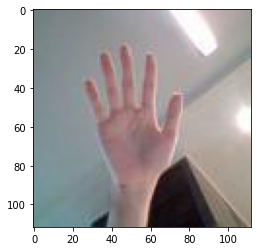

예측확률분포: [1.00000e+00 0.00000e+00 3.50873e-20]
라벨: 2, 예측결과: 0


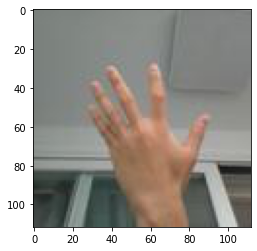

예측확률분포: [0. 1. 0.]
라벨: 2, 예측결과: 1


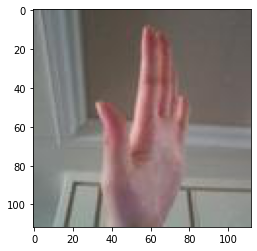

예측확률분포: [1. 0. 0.]
라벨: 2, 예측결과: 0


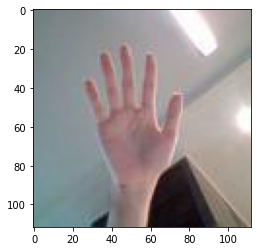

예측확률분포: [0. 1. 0.]
라벨: 0, 예측결과: 1


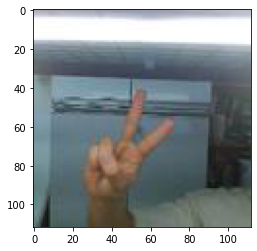

In [35]:
predicted_result = model.predict(x_test_new)  
predicted_labels = np.argmax(predicted_result, axis=1)

import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모음
    if predicted_labels[i] != y_test_new[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑기
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test_new[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test_new[n], cmap=plt.cm.binary)
    plt.show()

각도가 다른 이미지도 있지만 전체적으로 눈으로 봐서는 쉽게 구별이 가능한 이미지들을 잘못 예측했다. 장소, 밝기 등이 다른거나 눈에는 보이지않는 unseen data들에 의한 문제로 예상된다.

여기서 더 높은 성능의 모델을 만들고 싶다면
- 더 많고 다양한 데이터들을 수집
- 적절한 hyperparameter, hidden layer 결정  

등의 방법으로 모델을 개선 시킬 수 있을 것이라고 생각한다.